In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/divl/CVPDL/hw1/') ##改成自己儲存的資料夾路徑##

In [2]:
!pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00


In [6]:
from ultralytics import YOLO
import os, cv2, csv
import random
import shutil

IMAGE_FOLDER = "./train/img/"
GT_FILE = "./train/gt.txt"
LABEL_FOLDER = "./train/labels/"
TEST_FOLDER = "./test/img/"
os.makedirs(LABEL_FOLDER, exist_ok=True)

In [ ]:
gt = {}
with open(GT_FILE, "r") as f:
    for line in f:
        parts = line.strip().split(",")
        if len(parts) != 5:
            continue
        filename, x, y, w, h = parts
        x, y, w, h = int(x), int(y), int(w), int(h)
        if not filename.endswith(".jpg"):
            filename = f"{int(filename):08d}.jpg"
        gt.setdefault(filename, []).append((x, y, w, h))

for fname, boxes in gt.items():
    img_path = os.path.join(IMAGE_FOLDER, fname)
    if not os.path.exists(img_path):
        print("Missing:", img_path)
        continue
    img = cv2.imread(img_path)
    H, W = img.shape[:2]
    label_path = os.path.join(LABEL_FOLDER, os.path.splitext(fname)[0] + ".txt")
    with open(label_path, "w") as fw:
        for (x, y, w, h) in boxes:
            xc, yc = x + w/2, y + h/2
            fw.write(f"0 {xc/W:.6f} {yc/H:.6f} {w/W:.6f} {h/H:.6f}\n")

print("YOLO labels 已完成！")

Missing: /content/drive/MyDrive/divl/CVPDL/hw1/train/img/00000604.jpg
Missing: /content/drive/MyDrive/divl/CVPDL/hw1/train/img/00000605.jpg
Missing: /content/drive/MyDrive/divl/CVPDL/hw1/train/img/00000606.jpg
Missing: /content/drive/MyDrive/divl/CVPDL/hw1/train/img/00000607.jpg
YOLO labels 已完成！


In [10]:
import os
import random
import shutil

# 你的資料夾
img_dir = "./train/img"
label_dir = "./train/labels"

# 目標資料夾 (新 split)
base_out = "./dataset_split"
train_img_out = os.path.join(base_out, "images/train")
val_img_out = os.path.join(base_out, "images/val")
train_lbl_out = os.path.join(base_out, "labels/train")
val_lbl_out = os.path.join(base_out, "labels/val")

os.makedirs(train_img_out, exist_ok=True)
os.makedirs(val_img_out, exist_ok=True)
os.makedirs(train_lbl_out, exist_ok=True)
os.makedirs(val_lbl_out, exist_ok=True)

In [ ]:


# 取所有圖片檔
all_imgs = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
random.shuffle(all_imgs)

# 切 90% train, 10% val
split_idx = int(len(all_imgs) * 0.9)
train_imgs = all_imgs[:split_idx]
val_imgs = all_imgs[split_idx:]

def move_files(img_list, img_dest, lbl_dest):
    for img in img_list:
        # 複製圖片
        shutil.copy(os.path.join(img_dir, img), os.path.join(img_dest, img))
        # 複製對應 label
        lbl_name = img.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(label_dir, lbl_name)):
            shutil.copy(os.path.join(label_dir, lbl_name), os.path.join(lbl_dest, lbl_name))

move_files(train_imgs, train_img_out, train_lbl_out)
move_files(val_imgs, val_img_out, val_lbl_out)

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}")


Train: 1139, Val: 127


In [11]:
yaml_path = "./data.yaml"
with open(yaml_path, "w") as f:
    f.write(f"""
train: {train_img_out}
val: {val_img_out if os.path.exists(val_img_out) else IMAGE_FOLDER}
nc: 1
names: ['pig']
""")
print("data.yaml 已建立")

data.yaml 已建立


In [ ]:
model = YOLO("yolo11l.yaml")   # 可以換成 yolo11s.pt, yolo11m.pt 等
results = model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    # lr0=0.01,
    # lrf=0.01,
    project="./yolo11_output",
    name="exp6",
    # ======= Data Augmentation 設定 =======
    degrees=10,        # 隨機旋轉 ±10°
    translate=0.1,     # 平移 (10%)
    # scale=0.2,         # 縮放 (0.5~1.5)
    # shear=2.0,         # 剪切
    # flipud=0.0,        # 上下翻轉 (通常不建議用，除非物件上下顛倒沒差)
    fliplr=0.5,        # 左右翻轉 (50% 機率)
    # mosaic=0.5,        # Mosaic augmentation (開啟)
    # mixup=0.2,         # MixUp 機率
    # copy_paste=0.1     # Copy-Paste 機率
)

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/divl/CVPDL/hw1/data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

In [ ]:
#微調階段

# 載入第一階段 scratch 訓練好的模型
model = YOLO(f"./yolo11_output/exp6/weights/best.pt")

pretrained_model = YOLO("yolo11l.pt")
model_modules = list(model.model.named_children())
pretrained_modules = list(pretrained_model.model.named_children())

# the first 10 modules are the backbone and have the same names/structure
# You might need to adjust the range and names based on the specific YOLO versions
for i in range(min(10, len(model_modules), len(pretrained_modules))):
    name, module = model_modules[i]
    pretrained_name, pretrained_module = pretrained_modules[i]
    if name == pretrained_name:
        setattr(model.model, name, pretrained_module)
        # (選擇性) 凍結 backbone
        for param in getattr(model.model, name).parameters():
            param.requires_grad = True
    else:
        print(f"Warning: Module names do not match at index {i}: {name} vs {pretrained_name}. Skipping.")


# 進行 fine-tune
results_finetune = model.train(
    data=yaml_path,
    epochs=40,
    imgsz=640,
    batch=16,
    # lr0=0.01,
    # lrf=0.01,
    project="/content/drive/MyDrive/divl/CVPDL/hw1/yolo11_output",
    name="exp6_finetune",
    # ======= Data Augmentation 設定 =======
    degrees=10,        # 隨機旋轉 ±10°
    translate=0.1,     # 平移 (10%)
    scale=0.2,         # 縮放 (0.5~1.5)
    # shear=2.0,         # 剪切
    # flipud=0.0,        # 上下翻轉 (通常不建議用，除非物件上下顛倒沒差)
    fliplr=0.5,        # 左右翻轉 (50% 機率)
    mosaic=0.2,        # Mosaic augmentation (開啟)
    # mixup=0.2,         # MixUp 機率
    # copy_paste=0.1     # Copy-Paste 機率
)

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/divl/CVPDL/hw1/data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/divl/CVPDL/hw1/yolo11_output/exp6/weights/best.pt, momentum=0.937, mosaic=0.2, multi_scale=False, name=exp6_finetune, nbs=64, nms=False, opset=None, optimize=Fal

In [ ]:
# exp6_finetune
best_model = YOLO("./yolo11_output/exp6_finetune/weights/best.pt")
output_csv = "./yolo11_pred_finetune.csv"

TEST_FOLDER = "./test/img/"
test_images = sorted([x for x in os.listdir(TEST_FOLDER) if x.lower().endswith(".jpg")])

with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Image_ID", "PredictionString"])
    for img_name in test_images:
        img_path = os.path.join(TEST_FOLDER, img_name)
        results = best_model(img_path,
                    # conf=0.5
                             )
        det = results[0].boxes.xyxy.cpu().numpy()  # (N,4): x1,y1,x2,y2
        conf = results[0].boxes.conf.cpu().numpy()
        if det.shape[0] == 0:
            writer.writerow([os.path.splitext(img_name)[0], ""])
            continue
        parts = []
        for (x1, y1, x2, y2), c in zip(det, conf):
            w, h = x2 - x1, y2 - y1
            parts.append(f"{c:.4f} {int(x1)} {int(y1)} {int(w)} {int(h)} {0}")
        writer.writerow([os.path.splitext(img_name)[0], " ".join(parts)])

print("CSV 已完成:", output_csv)

串流輸出內容已截斷至最後 5000 行。
Speed: 1.0ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/divl/CVPDL/hw1/test/img/00000199.jpg: 384x640 31 pigs, 16.5ms
Speed: 1.1ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/divl/CVPDL/hw1/test/img/00000200.jpg: 384x640 32 pigs, 17.3ms
Speed: 1.4ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/divl/CVPDL/hw1/test/img/00000201.jpg: 384x640 28 pigs, 16.3ms
Speed: 1.1ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/divl/CVPDL/hw1/test/img/00000202.jpg: 384x640 32 pigs, 17.6ms
Speed: 1.1ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/divl/CVPDL/hw1/test/img/00000203.jpg: 384x640 31 pigs, 16.8ms
Speed: 1.1ms p


image 1/1 /content/drive/MyDrive/divl/CVPDL/hw1/test/img/00000600.jpg: 384x640 19 pigs, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


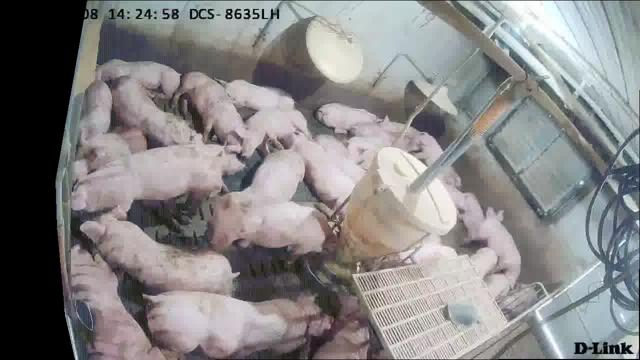

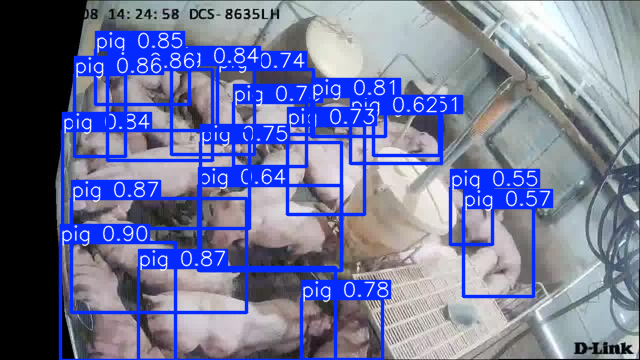

In [ ]:
from google.colab.patches import cv2_imshow
# exp2_finetune2
# exp5
best_model = YOLO("./yolo11_output/exp2_finetune2/weights/best.pt")
TEST_FOLDER = "./test/img/"
test_images = sorted([x for x in os.listdir(TEST_FOLDER) if x.lower().endswith(".jpg")])

# IMAGE_FOLDER = "./train/img/"

img_path = os.path.join(TEST_FOLDER, '00000600.jpg')
img = cv2.imread(img_path)

results = best_model(img_path,
            # iou=0.5,
            conf=0.5
                )
results[0].boxes.xyxy
cv2_imshow(img)
cv2_imshow(results[0].plot())

cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
!pip freeze > requirements.txt